NAVER_AI_TECH 최성준 교수님 강의자료

In [1]:
!pip install matplotlib==3.3.0

     |████████████████████████████████| 11.5MB 8.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Dataset 만들기

In [7]:
n_data = 10000
x_numpy = -3+6*np.random.rand(n_data,1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data,1) # 마지막 요소는 노이즈 추가한 것

In [12]:
x_numpy.shape, y_numpy.shape

((10000, 1), (10000, 1))

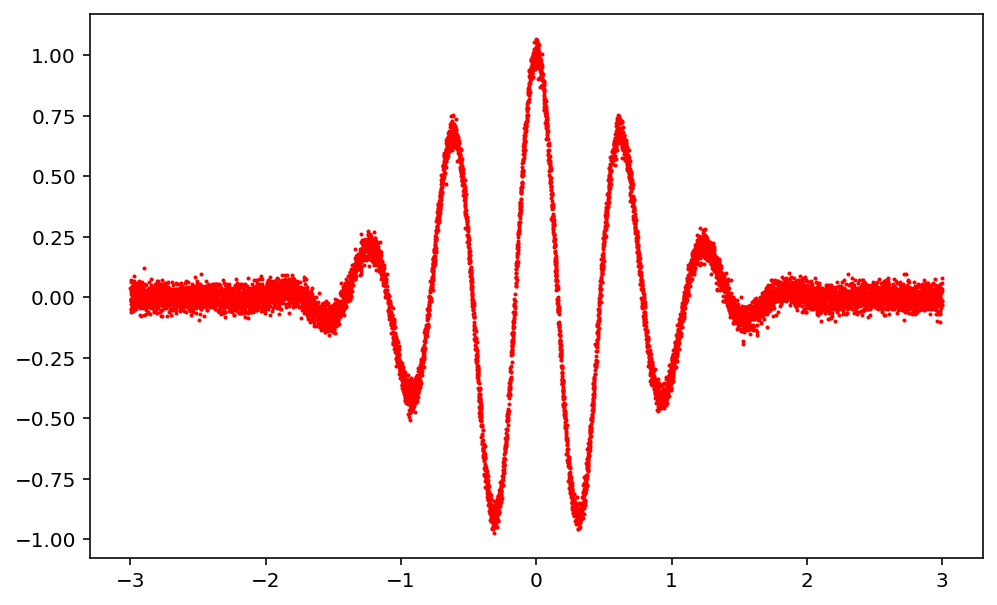

In [13]:
plt.figure(figsize=(8,5))
plt.plot(x_numpy, y_numpy, 'r.', ms=2)
plt.show()

In [14]:
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print("Done")

Done


In [52]:
class Model(nn.Module):
    def __init__(self, name='mlp', xdim=1, hdims=[16,16], ydim=1):
        super(Model, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdims = hdims
        self.ydim = ydim

        self.layers = []
        prev_hdim = self.xdim
        for hdim in self.hdims: # hidden dimension이 16인 레이어 2개가 만들어짐
            self.layers.append(nn.Linear(prev_hdim, hdim, bias=True))
            self.layers.append(nn.Tanh()) #activation
            prev_hdim = hdim
        
        #Final layer without activation
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))

        # Concatenate all layers
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = f"{type(layer).__name__.lower()}_{l_idx}"
            self.net.add_module(layer_name, layer)
        self.init_param()
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Linear): # m 모듈이 리니어인 경우
                nn.init.kaiming_normal_(m.weight) # he init으로 웨이트 초기화 해주고
                nn.init.zeros_(m.bias)

    def forward(self,x):
        return self.net(x)

print("done")

done


In [59]:
LEARNING_RATE = 1e-2

# Instantiate models
model_sgd = Model(name='mlp_sgd', xdim=1, hdims=[64,64], ydim=1).to(device)
model_momentum = Model(name='mlp_momentum', xdim=1, hdims=[64,64], ydim=1).to(device)
model_adam = Model(name='mlp_adam', xdim=1, hdims=[64,64], ydim=1).to(device)
#Optimizers
loss = nn.MSELoss()
optm_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)
optm_momentum = optim.SGD(model_momentum.parameters(), lr=LEARNING_RATE, momentum=0.9)
optm_adam = optim.Adam(model_adam.parameters(), lr=LEARNING_RATE)
print("Done")

Done


#파라미터 체크

In [60]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print(f"[{p_idx}] name:[{param_name}], shape:[{param_numpy.shape}]")
        print(f"    val:{param_numpy.reshape(-1)}")

[0] name:[net.linear_0.weight], shape:[(64, 1)]
    val:[ 0.079  2.177  0.392  0.2   -0.413  3.412  0.095  0.182  0.647 -1.037
 -0.596  0.274  0.562  2.106  2.337 -1.477  0.655 -1.863  1.354  1.156
  0.25   2.084 -0.56  -0.122  0.433 -0.588 -0.928 -0.32   0.201  0.071
 -1.13  -0.306 -2.629 -1.334 -0.287  0.08  -1.671 -1.628  0.198 -0.403
 -0.197 -1.061  0.638  1.598  0.961 -1.244 -0.05  -0.629  0.407  2.482
 -2.938  0.191  0.408 -0.097  1.358 -0.432  1.063 -1.586  0.325 -2.45
 -2.406 -1.272  1.872  2.342]
[1] name:[net.linear_0.bias], shape:[(64,)]
    val:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2] name:[net.linear_2.weight], shape:[(64, 64)]
    val:[-0.182 -0.173  0.001 ... -0.123  0.187  0.097]
[3] name:[net.linear_2.bias], shape:[(64,)]
    val:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

#Train

In [61]:
test_idx = np.random.permutation(50)
test_idx

array([31, 27,  1, 19,  4, 23, 25, 34, 17,  9,  5, 39, 35,  2, 30, 22, 29,
        7, 16, 49, 14, 38, 43, 46, 18, 12, 15,  6, 44, 40, 11,  8,  3, 10,
       45, 47, 41, 48, 42, 32, 36,  0, 26, 20, 21, 24, 28, 33, 37, 13])

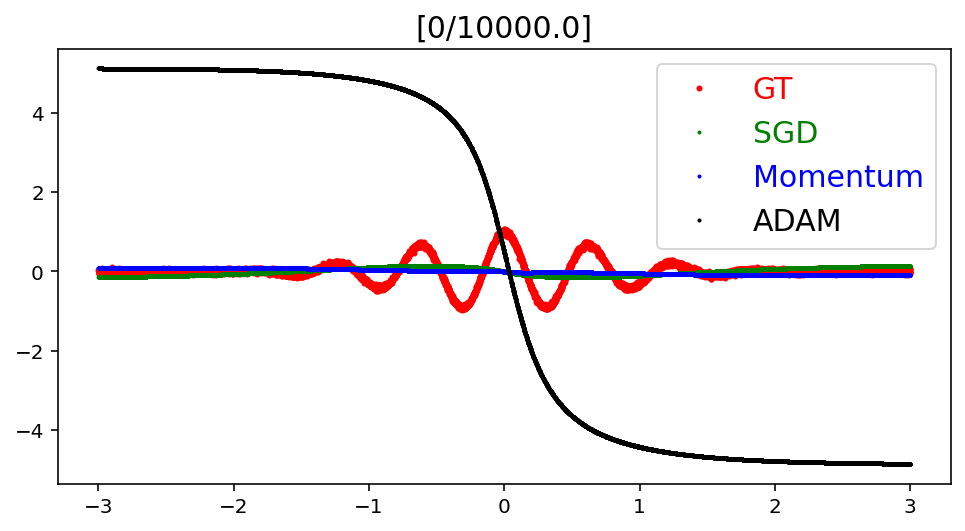

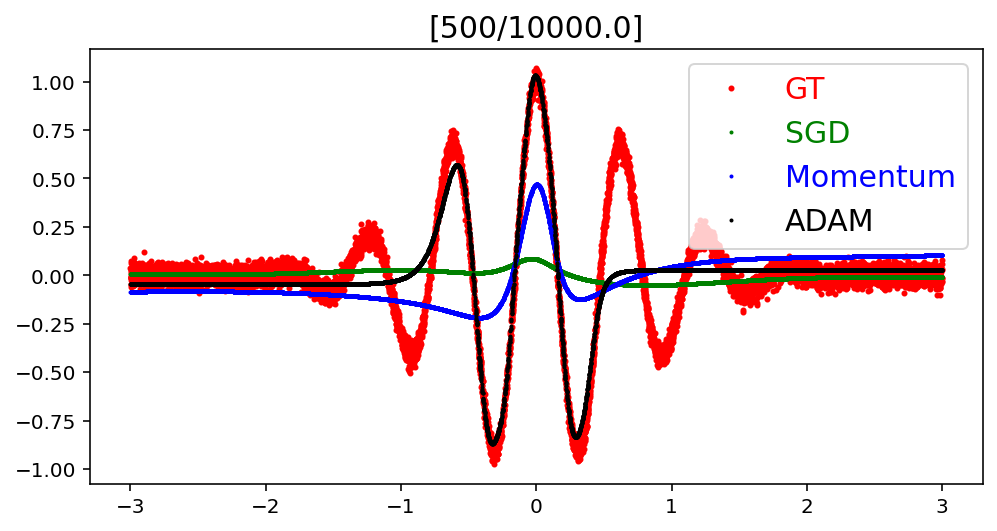

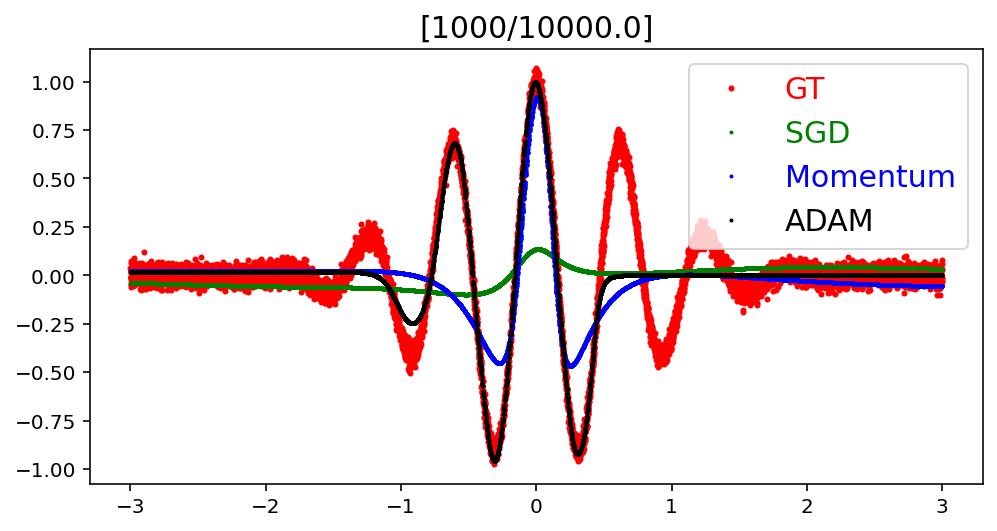

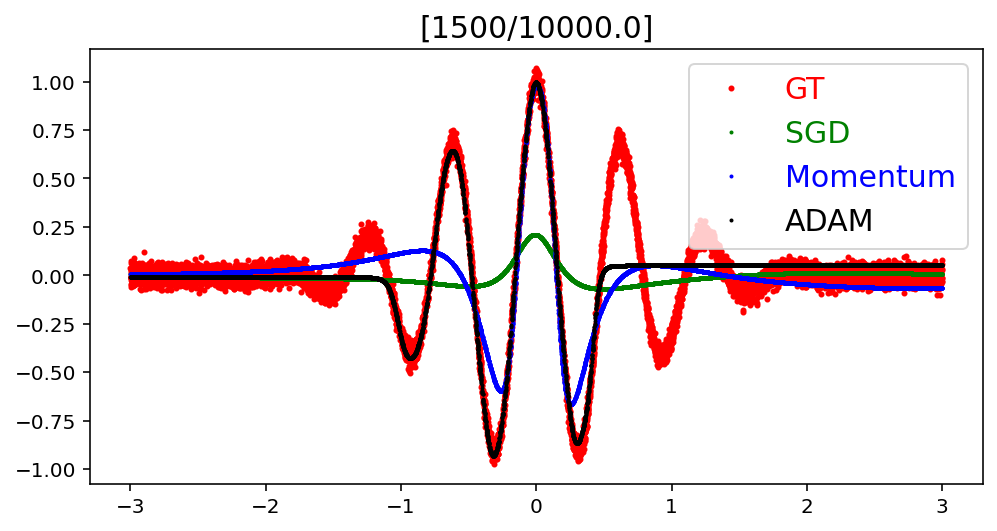

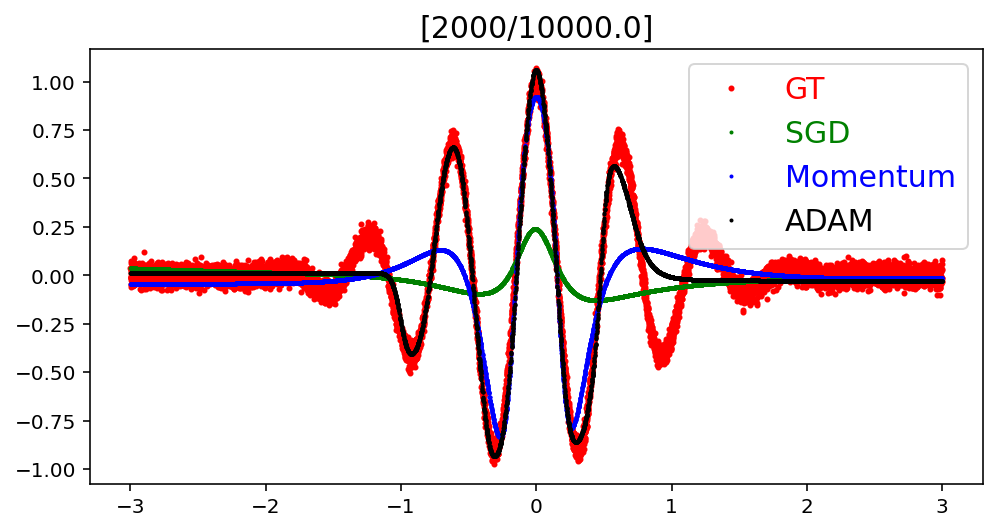

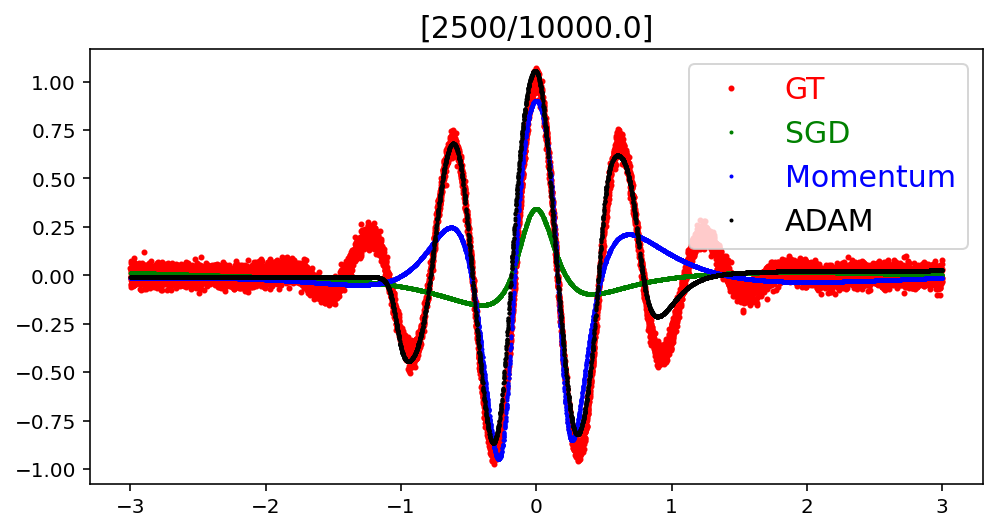

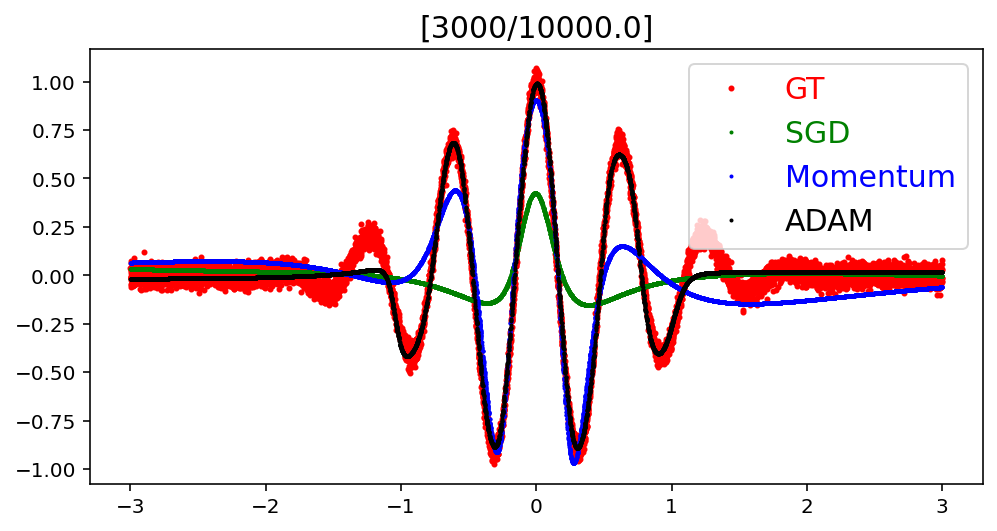

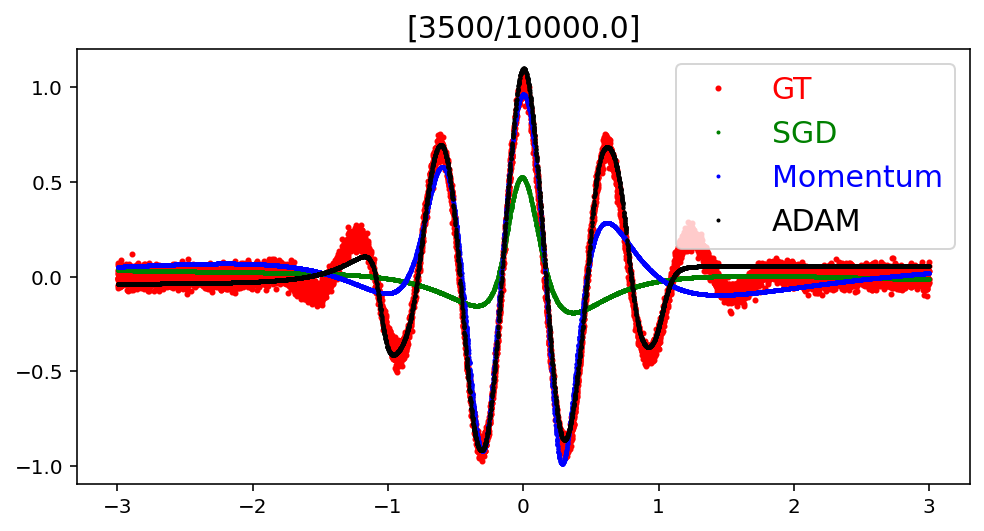

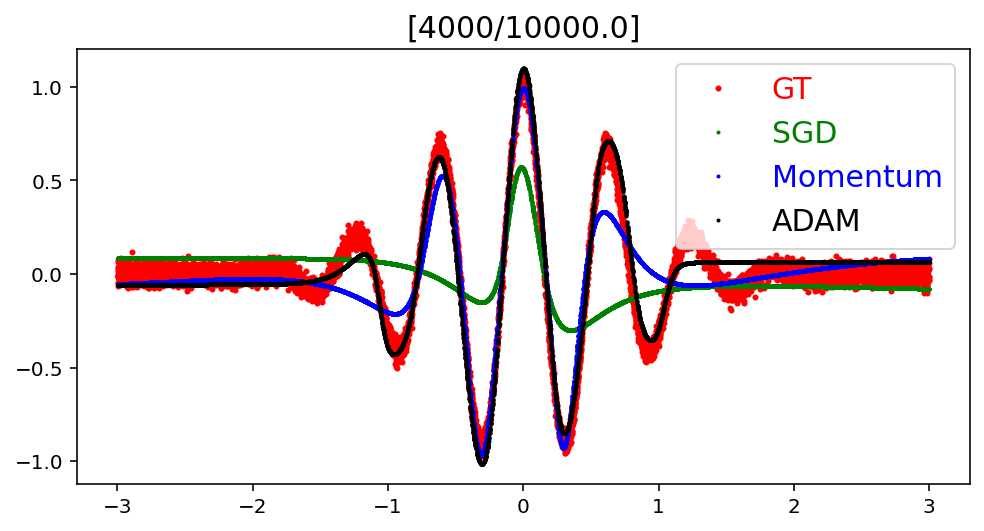

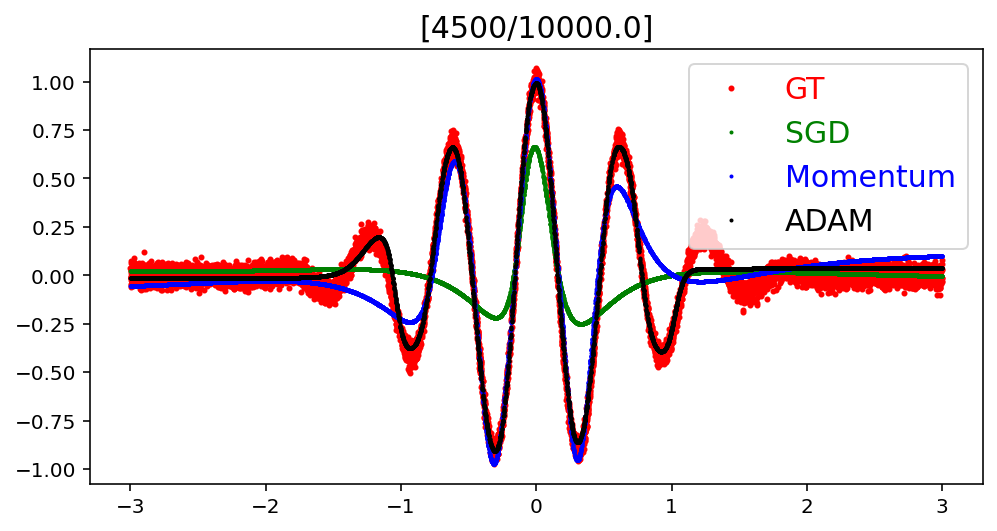

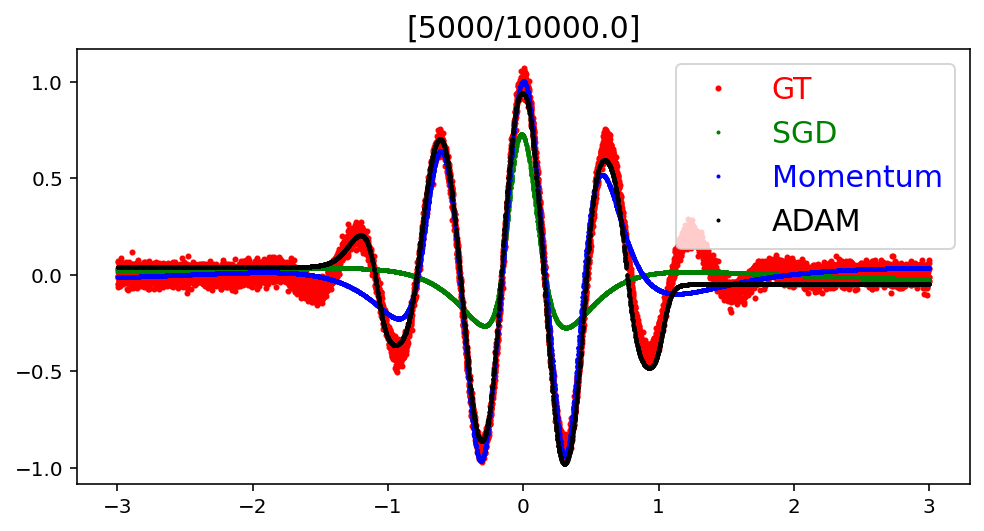

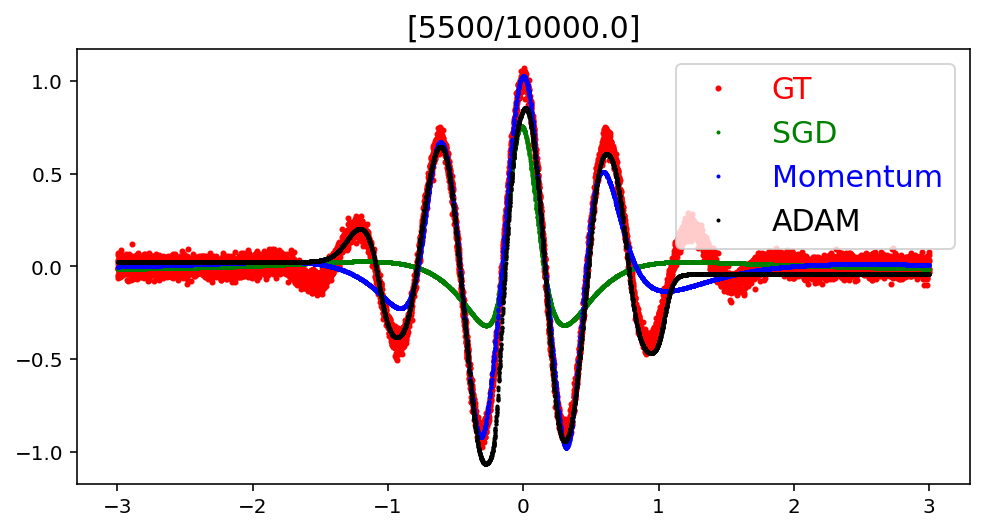

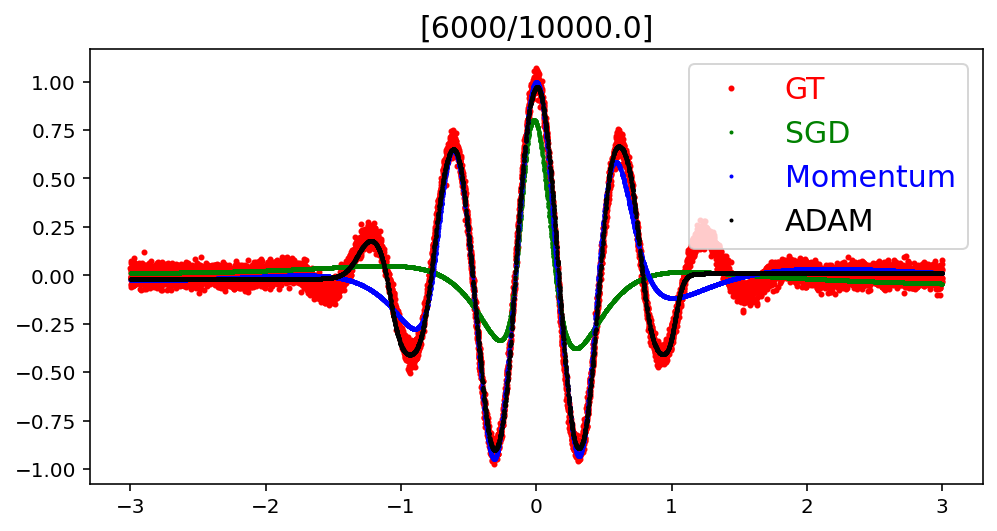

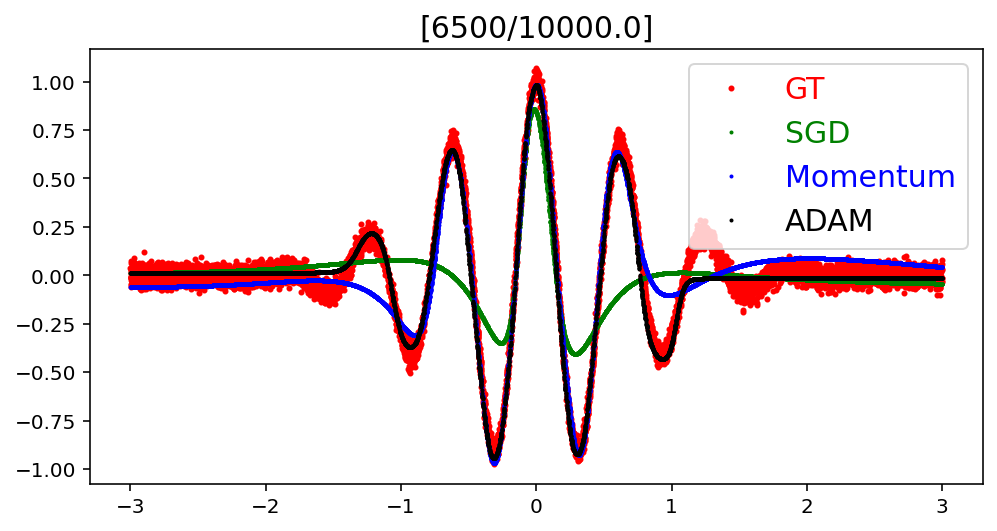

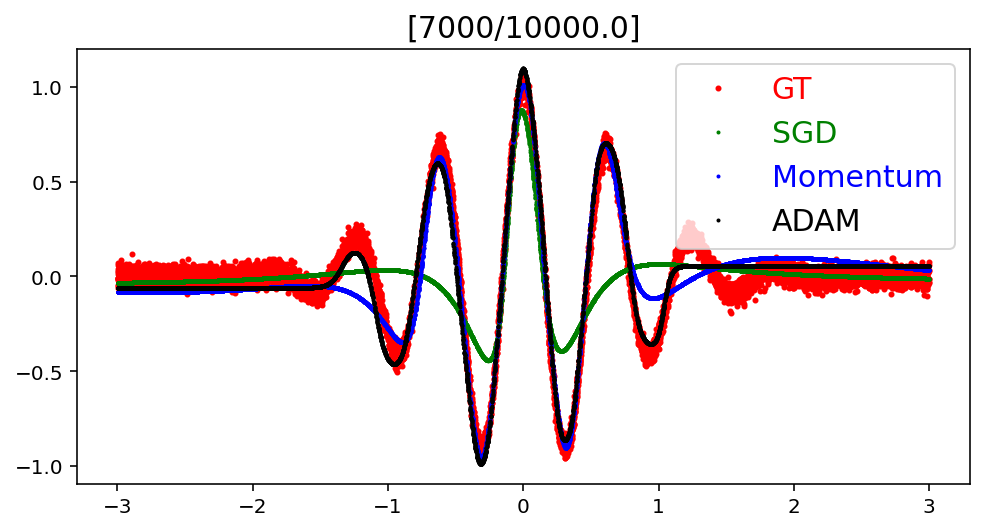

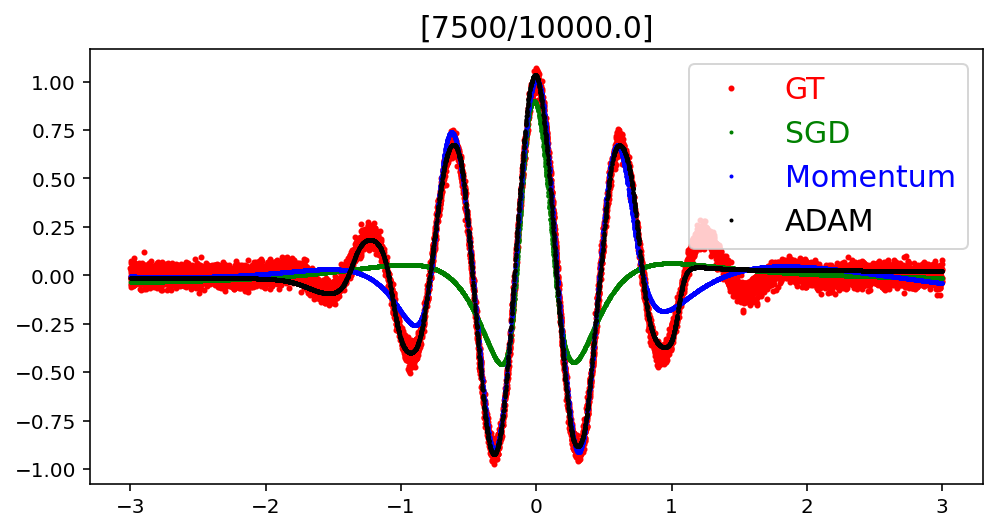

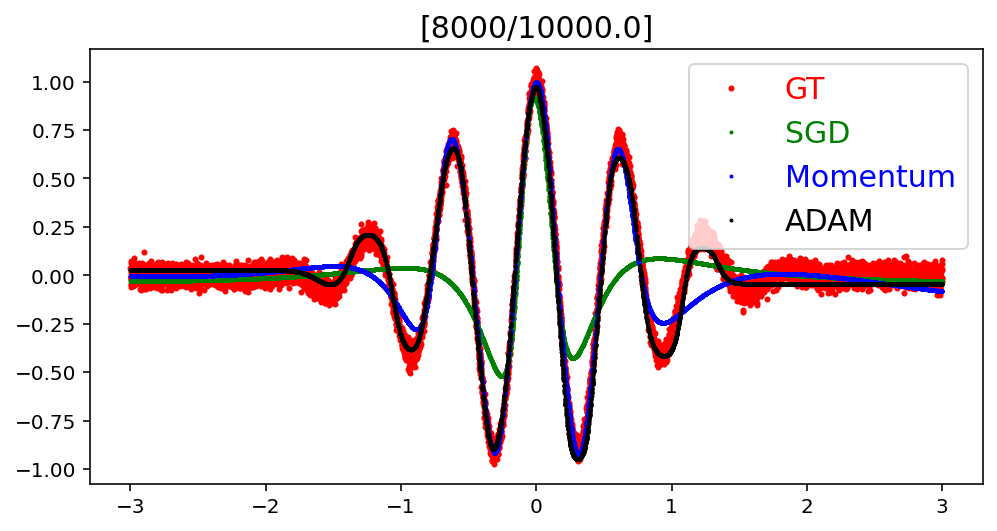

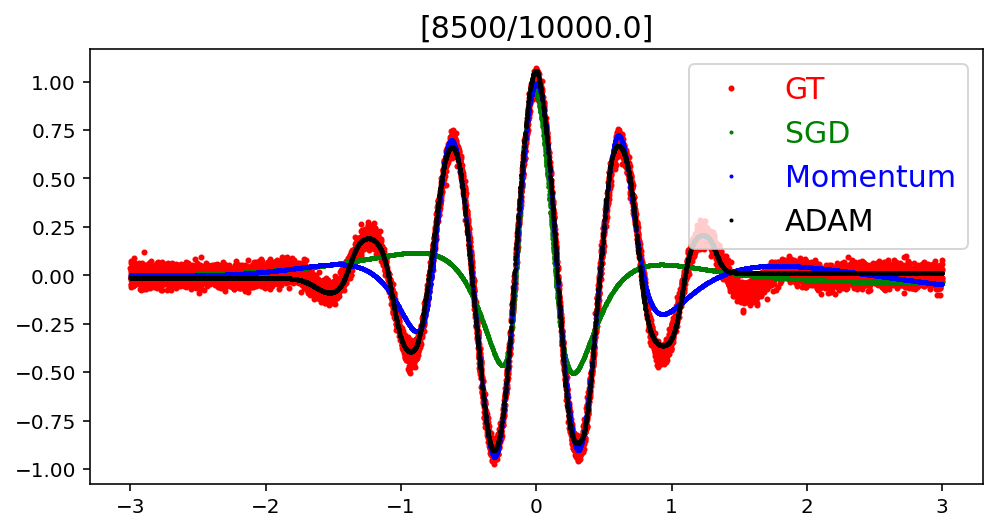

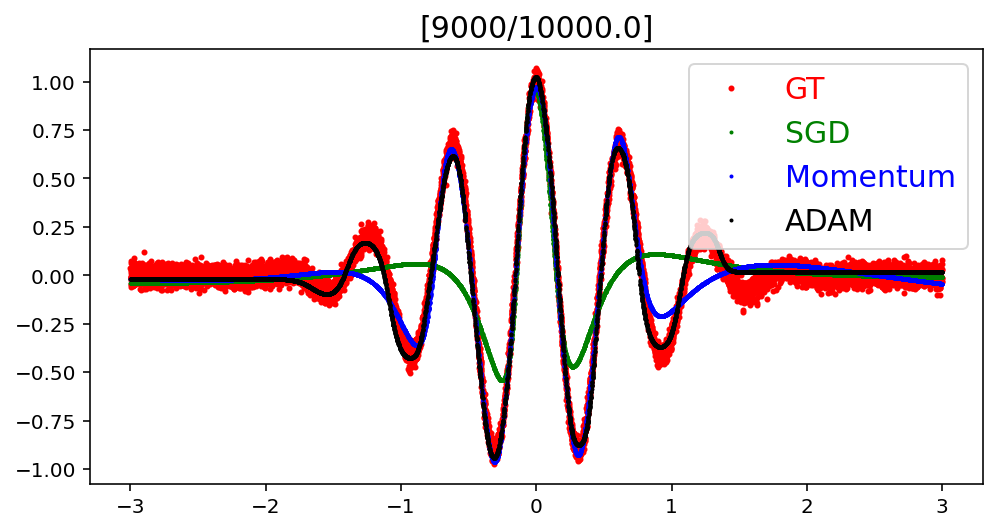

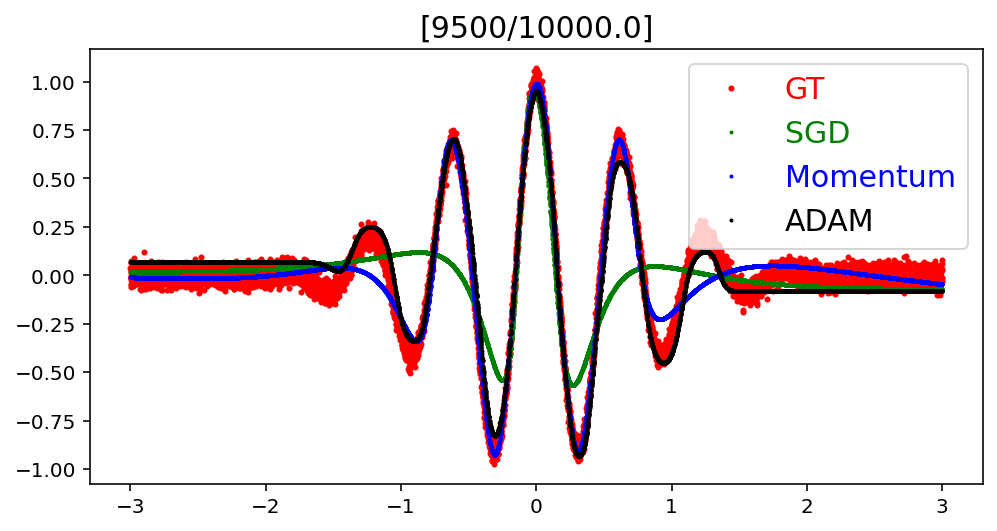

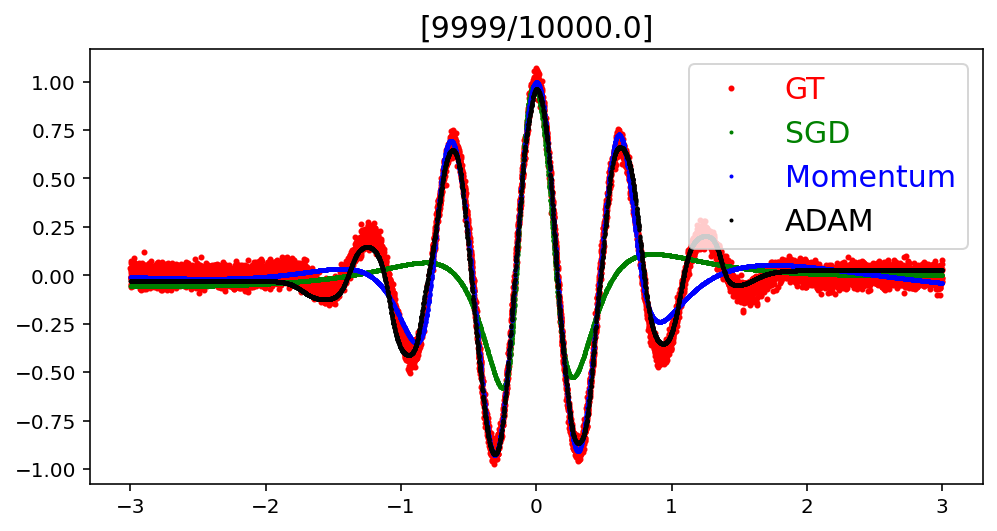

In [63]:
MAX_ITER, BATCH_SIZE, PLOT_EVERY = 1e4, 64, 500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x, batch_y = x_torch[r_idx], y_torch[r_idx]

    #Update with Adam
    y_pred_adam = model_adam.forward(batch_x)
    loss_adam = loss(y_pred_adam, batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()

    #Update with Momentum
    y_pred_momentum = model_momentum.forward(batch_x)
    loss_momentum = loss(y_pred_momentum, batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()

    #Update with sgd
    y_pred_sgd = model_sgd.forward(batch_x)
    loss_sgd = loss(y_pred_sgd, batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()

    #plot
    if ((it%PLOT_EVERY)==0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()

            plt.figure(figsize=(8,4))
            plt.plot(x_numpy, y_numpy, 'r.', ms=4, label='GT')
            plt.plot(x_numpy, y_sgd_numpy, 'g.', ms=2, label='SGD')
            plt.plot(x_numpy, y_momentum_numpy, 'b.', ms=2, label='Momentum')
            plt.plot(x_numpy, y_adam_numpy, 'k.', ms=2, label='ADAM')
            plt.title(f"[{it}/{MAX_ITER}]", fontsize=15)
            plt.legend(labelcolor='linecolor', loc='upper right', fontsize=15)
            plt.show()